### El objetivo del equipo

Es construir un análisis para abordar el mayor beneficio para la próxima campaña de marketing, programada para el próximo mes. La nueva campaña, la sexta, tiene como objetivo vender a una nueva base de datos de clientes.

**Para construir el análisis, se desarrollo una campaña piloto que involucró 2.240 clientes. Los clientes fueron seleccionados al azar y contactados por teléfono con respecto a la adquisición del gadget. Durante los meses siguientes, los clientes que compraron el oferta fueron debidamente etiquetados.**

El coste total de la campaña de muestra fue de 6.720MU y los ingresos generado por los clientes que aceptaron la oferta fue de 3.674MU. A nivel mundial, la campaña tuvo un beneficio de -3.046MU. La tasa de éxito de la campaña fue del 15%.


## 📍 Consideraciones


- Repliquen este notebook para la resolución del ejercicio.
- Consideren las etapas: 1) Cargamos los datos, 2) Preparación de la data, 3) Clasificación, 4) Regresión y 5) Guardar un modelo.

**Son libres de decidir:**

- Cómo preparar y acondicionar el dataset.
- Pueden agregar y eliminar columnas del dataset.
- Decidir parámetros para ajustar en los modelos de clasificación y regresión.


## 📍 Consigna


- Creen un modelo de clasificación utilizando Random Forest para la columna `Response`.
- Guarden el modelo de clasificación Randon forest como `rf.pkl`.
- Creen un modelo con regresión lineal y con Random Forest + GridsearchCV para predecir la columna `Income`.
- Cargar proyecto en Github / Gitlab, usen git y git-lfs para los `.csv` y `.pkl`.


<hr/>


In [32]:
import pandas as pd
from funpymodeling import status, profiling_num, freq_tbl
import datetime
import numpy as np

pd.set_option('display.max_columns', None)

data_original = pd.read_csv('marketing_campaign.csv', sep=';')
data_original.drop('ID', axis=1, inplace=True)
data = data_original.copy()

status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Year_Birth,0,0.000000,0,0.000000,59,int64
1,Education,0,0.000000,0,0.000000,5,object
2,Marital_Status,0,0.000000,0,0.000000,8,object
3,Income,24,0.010714,0,0.000000,1974,float64
4,Kidhome,0,0.000000,1293,0.577232,3,int64
5,Teenhome,0,0.000000,1158,0.516964,3,int64
6,Dt_Customer,0,0.000000,0,0.000000,663,object
7,Recency,0,0.000000,28,0.012500,100,int64
8,MntWines,0,0.000000,13,0.005804,776,int64
9,MntFruits,0,0.000000,400,0.178571,158,int64


In [33]:
data.shape

(2240, 28)

data['nivel_max_educativo'] = data['nivel_max_educativo'].astype('category')
data['nivel_max_educativo'] = data['nivel_max_educativo'].cat.add_categories('desconocido')
data['nivel_max_educativo'].fillna('desconocido', inplace=True)


In [34]:
today = datetime.date.today()

data['Age'] = today.year - data['Year_Birth']

row_to_delete = data.query('Age > 80').index
data.drop(row_to_delete, axis=0, inplace=True)
data['Age'] = pd.qcut(data['Age'], q=5, duplicates='drop')
data.drop('Year_Birth', axis=1, inplace=True)

In [35]:
data.drop('Z_CostContact', axis=1, inplace=True)
data.drop('Z_Revenue', axis=1, inplace=True)

In [36]:
def find_first_acceptance(row):
    campaigns = ['AcceptedCmp1', 'AcceptedCmp2',
                 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
    for i, cmp in enumerate(campaigns):
        if row[cmp] == 1:
            return i + 1
    return 0


data['AcceptedAfterNCampaigns'] = data.apply(find_first_acceptance, axis=1)
data.drop('AcceptedCmp1', axis=1, inplace=True)
data.drop('AcceptedCmp2', axis=1, inplace=True)
data.drop('AcceptedCmp3', axis=1, inplace=True)
data.drop('AcceptedCmp4', axis=1, inplace=True)
data.drop('AcceptedCmp5', axis=1, inplace=True)

In [37]:
data['Marital_Status'] = data['Marital_Status'].replace(
    {'Absurd': 'Single', 'YOLO': 'Single', 'Alone': 'Single'})

In [38]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
data['ErollmentAsClient'] = today.year - data['Dt_Customer'].dt.year
data.drop('Dt_Customer', axis=1, inplace=True)

In [39]:
def sum_amounts_spent(row):
    total_amount = 0
    amount_spend = ['MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntSweetProducts', 'MntWines', 'MntGoldProds']
    for i, amt in enumerate(amount_spend):
        total_amount += row[amt]
    return total_amount

data['AmountSpendInProducts'] = data.apply(sum_amounts_spent, axis=1)
data.drop('MntFishProducts', axis=1, inplace=True)
data.drop('MntMeatProducts', axis=1, inplace=True)
data.drop('MntFruits', axis=1, inplace=True)
data.drop('MntSweetProducts', axis=1, inplace=True)
data.drop('MntWines', axis=1, inplace=True)
data.drop('MntGoldProds', axis=1, inplace=True)

In [40]:
def sum_total_purchases(row):
    total_purchases = 0
    purchases = ['NumDealsPurchases', 'NumWebPurchases',
                 'NumCatalogPurchases', 'NumStorePurchases']
    for i, amt in enumerate(purchases):
        total_purchases += row[amt]
    return total_purchases


data['TotalPurchases'] = data.apply(sum_total_purchases, axis=1)
data.drop('NumDealsPurchases', axis=1, inplace=True)
data.drop('NumWebPurchases', axis=1, inplace=True)
data.drop('NumCatalogPurchases', axis=1, inplace=True)
data.drop('NumStorePurchases', axis=1, inplace=True)

In [41]:
# Creamos una copia para hacer la regresion
data_for_regression = data.copy()

In [42]:
data = data[data['Income'] <= 95000]
data['Income'] = pd.qcut(data['Income'], q=5, duplicates='drop')


# data['Income'] = data['Income'].astype('category')
# data['Income'] = data['Income'].cat.add_categories('desconocido')
# data['Income'] = data['Income'].fillna(value='desconocido')
# freq_tbl(data['Income'])

In [43]:
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Education,0,0.0,0,0.000000,5,object
1,Marital_Status,0,0.0,0,0.000000,5,object
2,Income,0,0.0,0,0.000000,5,category
3,Kidhome,0,0.0,1256,0.574828,3,int64
4,Teenhome,0,0.0,1119,0.512128,3,int64
5,Recency,0,0.0,28,0.012815,100,int64
6,NumWebVisitsMonth,0,0.0,6,0.002746,16,int64
7,Complain,0,0.0,2166,0.991304,2,int64
8,Response,0,0.0,1863,0.852632,2,int64
9,Age,0,0.0,0,0.000000,5,category


In [44]:
data_ohe = pd.get_dummies(data)

In [45]:

X_data = data_ohe.drop('Response', axis=1)
y_data = data_ohe['Response']
X_data = X_data.values
y_data = y_data.values

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

x_train, x_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=1)

# under_sampler = RandomUnderSampler(random_state=1)
# X_us, y_us = under_sampler.fit_resample(x_train, y_train)
# x_train = X_us
# y_train = y_us


# over_sampler = RandomOverSampler()
# X_os, y_os = over_sampler.fit_resample(x_train, y_train)
# x_train = X_os
# y_train = y_os

best_params = {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

rf_classifier = RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2)

In [47]:
# en training
pred_tr = rf_classifier.predict(x_train)
# obtenemos la probabilidad binaria de que pertenezca a cada clase (Si o No)
pred_tr_prob = rf_classifier.predict_proba(x_train)
tr_probs = pred_tr_prob[:,1] # Nos quedamos con la probabilidad de clase 1 (Si)

# en testing
pred_ts = rf_classifier.predict(x_test)

In [48]:
# Crea un DF con los datos de la realidad de lo que paso con Y y al lado lo que el modelo predijo de Y
df_val_tr = pd.DataFrame({'y_train': y_train, 'pred_tr': pred_tr})

tr_model_score = sum(df_val_tr.y_train == df_val_tr.pred_tr) / len(y_train)

tr_model_score

0.9587965990843689

In [49]:
from sklearn.metrics import accuracy_score

ts_model_score = accuracy_score(y_test, pred_ts, normalize=True)
ts_model_score

0.8734756097560976

In [50]:
diff = tr_model_score - ts_model_score
diff

0.08532098932827126

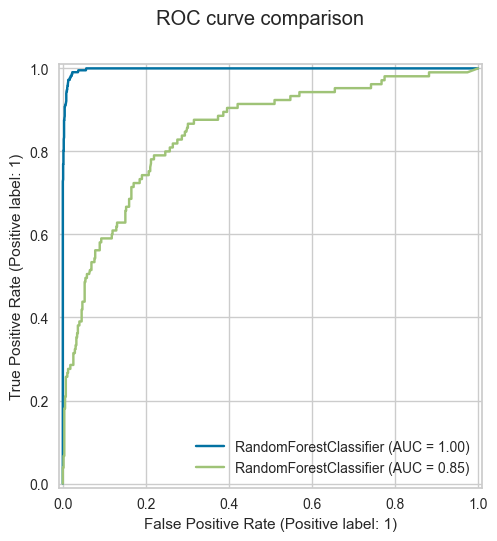

In [51]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

tr_disp = RocCurveDisplay.from_estimator(rf_classifier, x_train, y_train)
ts_disp = RocCurveDisplay.from_estimator(rf_classifier, x_test, y_test, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("ROC curve comparison")

plt.show()

# 🫠 Podemos apreciar que el modelo en training esta sobreajustando. Vamos a ver si podemos mejorar esto, modificando los parametros de aprendizaje

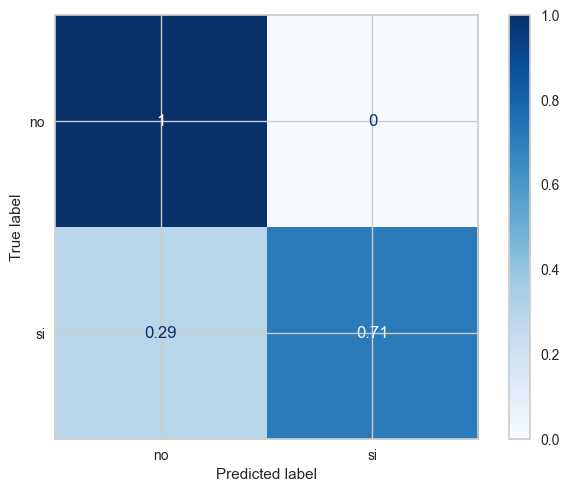

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


ConfusionMatrixDisplay.from_estimator(
    rf_classifier, x_train, y_train,
    display_labels=['no','si'],
    cmap='Blues',
    normalize='true'
    )

In [53]:
conf_mat1=pd.crosstab(index=y_train, 
                      columns=pred_tr,   
                      rownames=['Actual'], 
                      colnames=['Pred'], 
                      normalize='index')

# sns.heatmap(conf_mat1, annot=True, cmap='Blues', fmt='g')
print(conf_mat1)

Pred           0         1
Actual                    
0       1.000000  0.000000
1       0.290323  0.709677


In [54]:
tr_probs.mean()
tr_probs_2 = np.where(tr_probs > 0.30, 1, 0) # El punto de corte 0.30 fue provisto por la libreria yellowbrick

conf_mat2=pd.crosstab(index=y_train, 
                      columns=tr_probs_2,    
                      rownames=['Actual'], 
                      colnames=['Pred'], 
                      normalize='index')

# sns.heatmap(conf_mat2, annot=True, cmap='Blues', fmt='g')
print(conf_mat2)

Pred           0         1
Actual                    
0       0.973323  0.026677
1       0.009217  0.990783


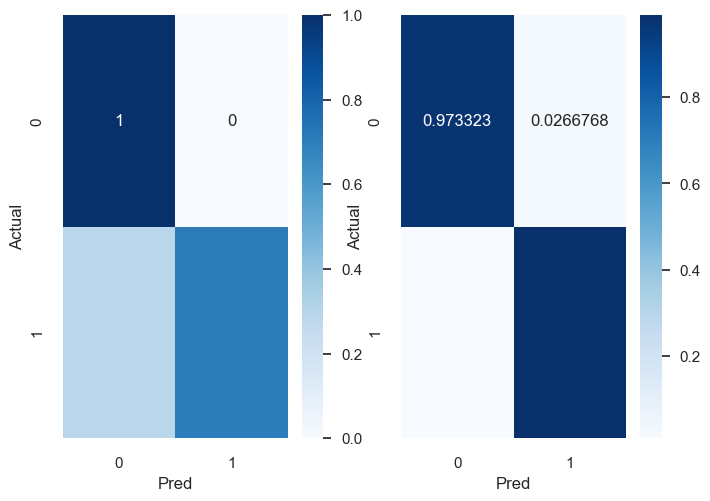

In [55]:
sns.set(font_scale=1)       # Ajuste tamaño de letra (var global)
fig, ax = plt.subplots(1,2)  

sns.heatmap(conf_mat1, annot=True, cmap='Blues', fmt='g', ax=ax[0])
sns.heatmap(conf_mat2, annot=True, cmap='Blues', fmt='g', ax=ax[1])

fig.show(warn=False)

In [56]:
# from yellowbrick.classifier import DiscriminationThreshold

# visualizer = DiscriminationThreshold(rf)

# visualizer.fit(x_train, y_train)     
# visualizer.show()                      

In [57]:
from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300, 100],  # Número de árboles en el bosque.
#     'max_depth': [None, 10, 20, 30],  # Máxima profundidad de los árboles.
#     'min_samples_split': [2, 5, 10],  # Número mínimo de muestras necesarias para dividir un nodo.
#     'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en una hoja.
#     'bootstrap': [True, False]  # Método para muestrear puntos de datos (con o sin reemplazo).
# }

# # Instanciar GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# grid_search.fit(x_train, y_train)
# best_params = grid_search.best_params_
# print(f"Mejores parámetros: {best_params}")

# # Mejor modelo encontrado por GridSearch
# best_model = grid_search.best_estimator_
# print(f"Mejor modelo: {best_model}")

# pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
#            pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
#                         columns=["neg_mean_absolute_error"])],axis=1).sort_values('neg_mean_absolute_error', ascending=False)

# Regresión 📈

In [58]:
profiling_num(data_for_regression['Income'])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,Income,52191.130159,25196.493654,0.482773,7521.12,18980.0,35196.0,51369.0,68487.0,84077.0,94468.48


In [59]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score


data_regression = pd.get_dummies(data_for_regression)
data_regression.dropna(inplace=True)
data_regression = data_regression[data_regression['Income'] <= 95000]
y_data_regression = data_regression['Income']
X_data_regression = data_regression.drop('Income', axis=1)

y_data = y_data_regression.values
X_data = X_data_regression.values

x_train, x_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=1)


# params = {
#     'n_estimators': [100, 200, 300, 100],  # Número de árboles
#     'max_depth': [None, 10, 20, 30],  # Profundidad máxima de cada árbol
#     'min_samples_split': [2, 5, 10],  # Número mínimo de muestras necesarias para dividir un nodo
#     'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en una hoja
#     'bootstrap': [True, False]  # Método para muestrear puntos de datos
# }

# grid_rf = GridSearchCV(estimator=model_rf, param_grid=params,
#                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# grid_rf.fit(x_train, y_train)

# pd.concat([pd.DataFrame(grid_rf.cv_results_["params"]),
#            pd.DataFrame(grid_rf.cv_results_["mean_test_score"], 
#                         columns=["neg_mean_absolute_error"])],axis=1).sort_values('neg_mean_absolute_error', ascending=False)

best_params = {	'bootstrap': True,	'max_depth': 30.0,	'min_samples_leaf': 2,	'min_samples_split': 5,	'n_estimators': 100 }
rf_regressor = RandomForestRegressor(bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
rf_regressor.fit(x_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = rf_regressor.predict(x_test)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 55492539.04502401
R^2 Score: 0.8700702257078938


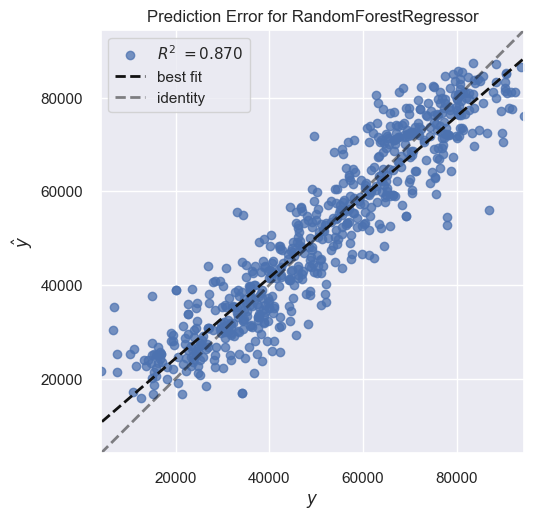

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [60]:
from yellowbrick.regressor import PredictionError

vis_pred_err = PredictionError(rf_regressor)

vis_pred_err.fit(x_train, y_train)  # Fiteamos los datos al visualizador
vis_pred_err.score(x_test, y_test)  # Calculamos las métricas para test
vis_pred_err.show()                 # Visualizamos!

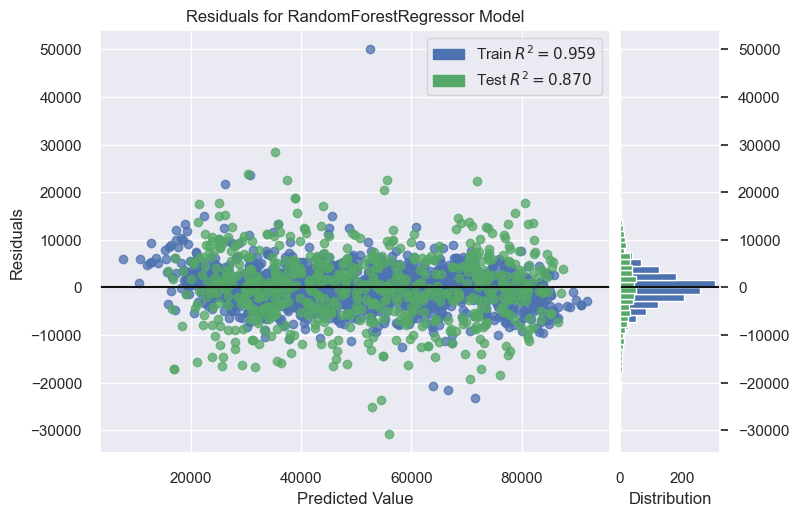

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [61]:
from yellowbrick.regressor import ResidualsPlot

# ojo: poner best_estimator_
vis_res = ResidualsPlot(rf_regressor)


# Copy-paste de la doc oficial: 
vis_res.fit(x_train, y_train)  # Fiteamos los datos al visualizador
vis_res.score(x_test, y_test)  # Calculamos las métricas para test
vis_res.show()                 # Visualizamos!

In [62]:
import pickle

pickle.dump(rf_classifier, open('rf_classifier.pkl', 'wb')) # rf = nuestro modelo
pickle.dump(rf_regressor, open('rf_regressor.pkl', 'wb')) # rf = nuestro modelo